# Код для магістерської роботи

# Лінійна регресія та випадковий ліс

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Дані з предикторами та цільовими значеннями для прогнозу бажано завантажувати у форматі .csv, позначаючи цільове значення як 'y'. Дані попередньо мають бути переведені у числовий вигляд, також це можна зробити за допомогою LabelEncoder. Для лінійної регресії рекомендується їх також нормалізувати.

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
X = data.loc[data.columns!='y'].values
y = data.y.values

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False,
                                                    test_size=.2)


Навчання моделей та перевірка похибки

In [ ]:
lr = LinearRegression()
rf = RandomForestRegressor()

lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

test_preds_lr = lr.predict(X_test)
test_preds_rf = rf.predict(X_test)

print(f'Похибка лінійної регресії: {mean_squared_error(y_test, test_preds_lr)}')
print(f'Похибка випадкового лісу: {mean_squared_error(y_test, test_preds_rf)}')

Завантаження предикторів для фактичного прогнозу (характеристики кандидатів на підвищення)

In [ ]:
new_data = pd.read_csv('new_data.csv')

Прогноз

In [ ]:
lr.fit(X,y)
rf.fit(X,y)

actual_preds_lr = lr.predict(new_data.values)
actual_preds_rf = rf.predict(new_data.values)

Вивантаження прогнозних даних

In [ ]:
post_comp = pd.DataFrame()
post_comp['Прогноз лінійної регресії'] = list(actual_preds_lr)
post_comp['Прогноз виипадкового лісу'] = list(actual_preds_rf)
post_comp.to_csv('predictions.csv', index=False)

# Агентне моделювання

Необхідно скласти словник, де ключем є номер ієрархічного рівня "Феофанії", а значенням - середня варіація у переході компетентностей при попередніх підвищеннях на цей рівень. Мають бути зазначені усі 5 рівнів - заступники головного лікаря, керівники центрів, вищий, середній та молодший медичний персонал.

In [ ]:
level_vars = {}

Сама модель

In [ ]:
def get_random(mode, value=None, level_num=None):
  ran = 0

  if mode=='competence_peter' or mode=='competence':
    while ran>10. or ran<1.:
      ran = random.gauss(7, 2)
    return ran

  elif mode == 'competence_common':
    variation = np.random.uniform(-1, 1)
    while value+variation<1. or value+variation>10.:
      variation = np.random.uniform(-1, 1)
    return value+variation

  elif mode == 'custom':
    return value+level_vars[level_num]

  elif mode=='age':
    while int(ran) not in range(18,61):
      ran = random.gauss(25, 5)
    return int(ran)



def promotion_strategy(criterion='random', hypothesis='peter', epochs=1000):

  num_levels = 5
  options = [min, max, random.choice]
  efficiency = []

  coefs = np.array([.8,.7,.5,.4,.2]) #коефіцієнти відповідальнсті рівня
  
  #чисельність працівників на кожному рівні, їх середній вік та рівень компетентності
  #при реальному моделюванні сюди необхідно внести актуальну інформацію про кандидатів
  
  hierarchy = [
  [[42, get_random('competence')] for i in range(5)],
  [[45, get_random('competence')] for i in range(51)],
  [[45, get_random('competence')] for i in range(300)],
  [[30, get_random('competence')] for i in range(600)],
  [[50, get_random('competence')] for i in range(440)]
  ]

  param = dict(zip(range(num_levels), [len(level) for level in hierarchy]))


  max_competences = np.array([10*len(level) for level in hierarchy])

  for epoch in range(epochs):
    #print('Start of cycle')
    level_competences = np.array([sum([i[1] for i in level]) for level in hierarchy])
    org_ef = np.matmul(coefs, level_competences)
    efficiency.append(org_ef/((np.matmul(coefs, max_competences)/1396) * 1396))

    for level in hierarchy:
      for worker in level:
        if worker[0]>60 or worker[1]<4:
          level.remove(worker)
    while [len(i) for i in hierarchy]!=[param[i] for i in range(num_levels)]:
      for level in hierarchy:
        if len(level)!=param[hierarchy.index(level)]:
          if hierarchy.index(level) != len(hierarchy)-1:
            prev = hierarchy[hierarchy.index(level)+1]
            if criterion=='best':
              chosen = prev[[k[1] for k in prev].index(max([k[1] for k in prev]))]
            elif criterion=='worst':
              chosen = prev[[k[1] for k in prev].index(min([k[1] for k in prev]))]
            elif criterion=='random':
              chosen = prev[[k[1] for k in prev].index(random.choice([k[1] for k in prev]))]
            elif criterion=='random_min_max':
              chosen = prev[[k[1] for k in prev].index(random.choice(options)([k[1] for k in prev]))]
            hierarchy[hierarchy.index(level)+1].remove(chosen)
            if hypothesis == 'peter':
              level.append([chosen[0], get_random('competence_peter')]) 
            elif hypothesis == 'common':
              level.append([chosen[0], get_random('competence_common', chosen[1])])
            elif hypothesis == 'custom':
              level.append([chosen[0], get_random('competence_custom', chosen[1], 
                                                  hierarchy.index(level))])

          else:

            level.append([get_random('age'), get_random('competence')])

    #print('End of cycle', [len(i) for i in hierarchy])
    
    for level in hierarchy:
      for worker in level: 
        age = worker[0]+1
        worker[0] = age
    
 
  
  return efficiency

In [ ]:
def simulate_ntimes(epochs=1000, hypothesis='peter', n=50):
  rand = np.zeros(epochs)
  best = np.zeros(epochs)
  worst = np.zeros(epochs)
  rand_min_max = np.zeros(epochs)
  
  for i in range(n):
    efficiency_random = np.array(promotion_strategy('random', hypothesis, epochs))
    rand += efficiency_random

    efficiency_best = np.array(promotion_strategy('best', hypothesis, epochs))
    best += efficiency_best

    efficiency_worst = np.array(promotion_strategy('worst', hypothesis, epochs))
    worst += efficiency_worst

    efficiency_rand_min_max = np.array(promotion_strategy('random_min_max', hypothesis, epochs))
    rand_min_max += efficiency_rand_min_max

  return [rand/n, best/n, worst/n, rand_min_max/n]

In [ ]:
epochs = 1000
efficiency = simulate_ntimes(epochs=epochs)

Результати симулювання організаційної ефективності з урахуванням характеристик персоналу "Феофанії", зокрема кандидатів на підвищення. Варто обрати того кандидата (-тів), рівень апріорної компетентності відповідає найефективнішій стратегії підвищення, тобто тій, яка показала найкращий розвиток згідно моделювання.

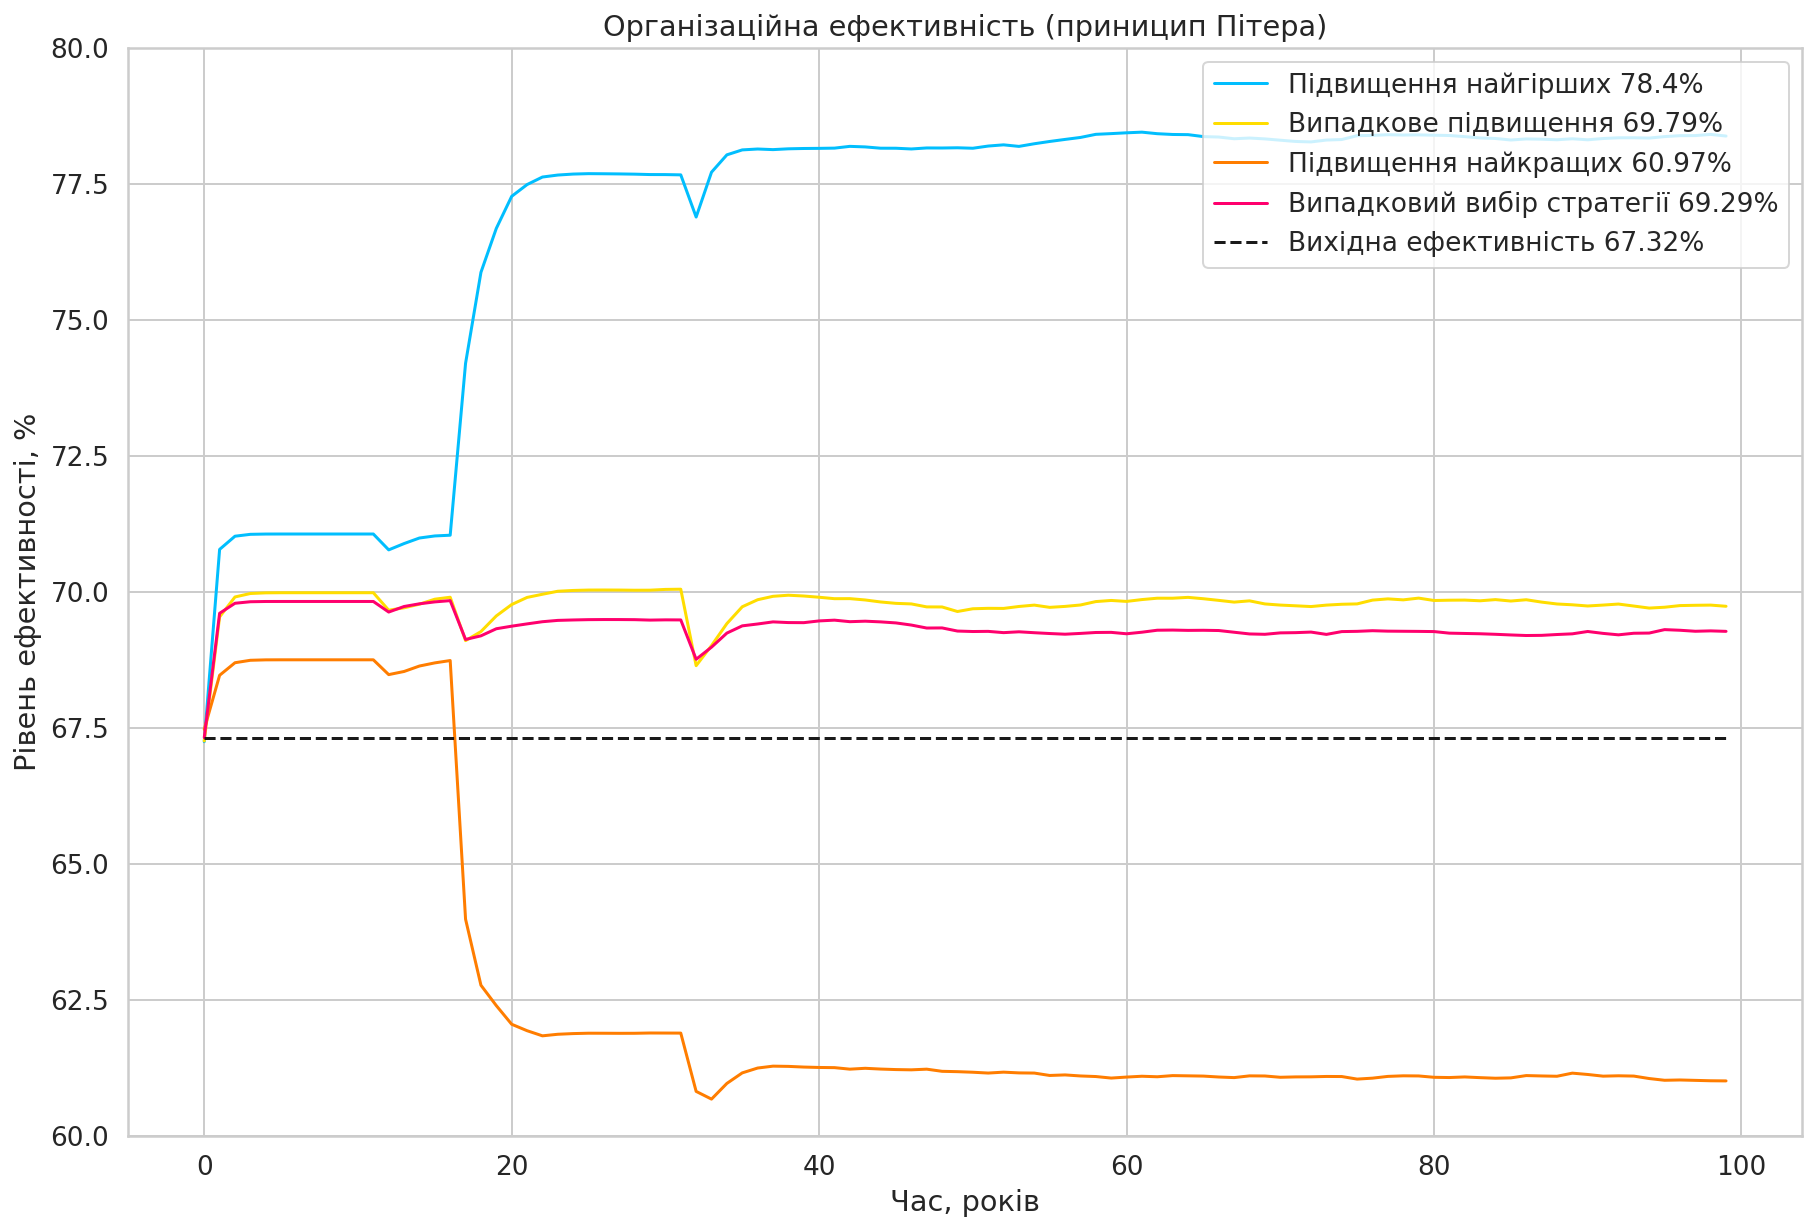

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 15, 10
plt.plot(range(epochs)[:100], efficiency[2][:100]*100, 
         label=f'Підвищення найгірших {round(np.mean(efficiency[2][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], efficiency[0][:100]*100, 
         label=f'Випадкове підвищення {round(np.mean(efficiency[0][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], efficiency[1][:100]*100, 
         label=f'Підвищення найкращих {round(np.mean(efficiency[1][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], efficiency[3][:100]*100, 
         label=f'Випадковий вибір стратегії {round(np.mean(efficiency[3][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], 
         [round(np.mean([i[0] for i in efficiency])*100, 2)]*100, '--', 
         color='k', 
         label=f'Вихідна ефективність {round(np.mean([i[0] for i in efficiency])*100, 2)}%')

plt.ylim(60,80)
plt.title('Організаційна ефективність (приницип Пітера)')
plt.ylabel('Рівень ефективності, %')
plt.xlabel('Час, років')
plt.legend(loc='upper right')



In [ ]:
efficiency = simulate_ntimes(epochs=epochs, hypothesis='common')

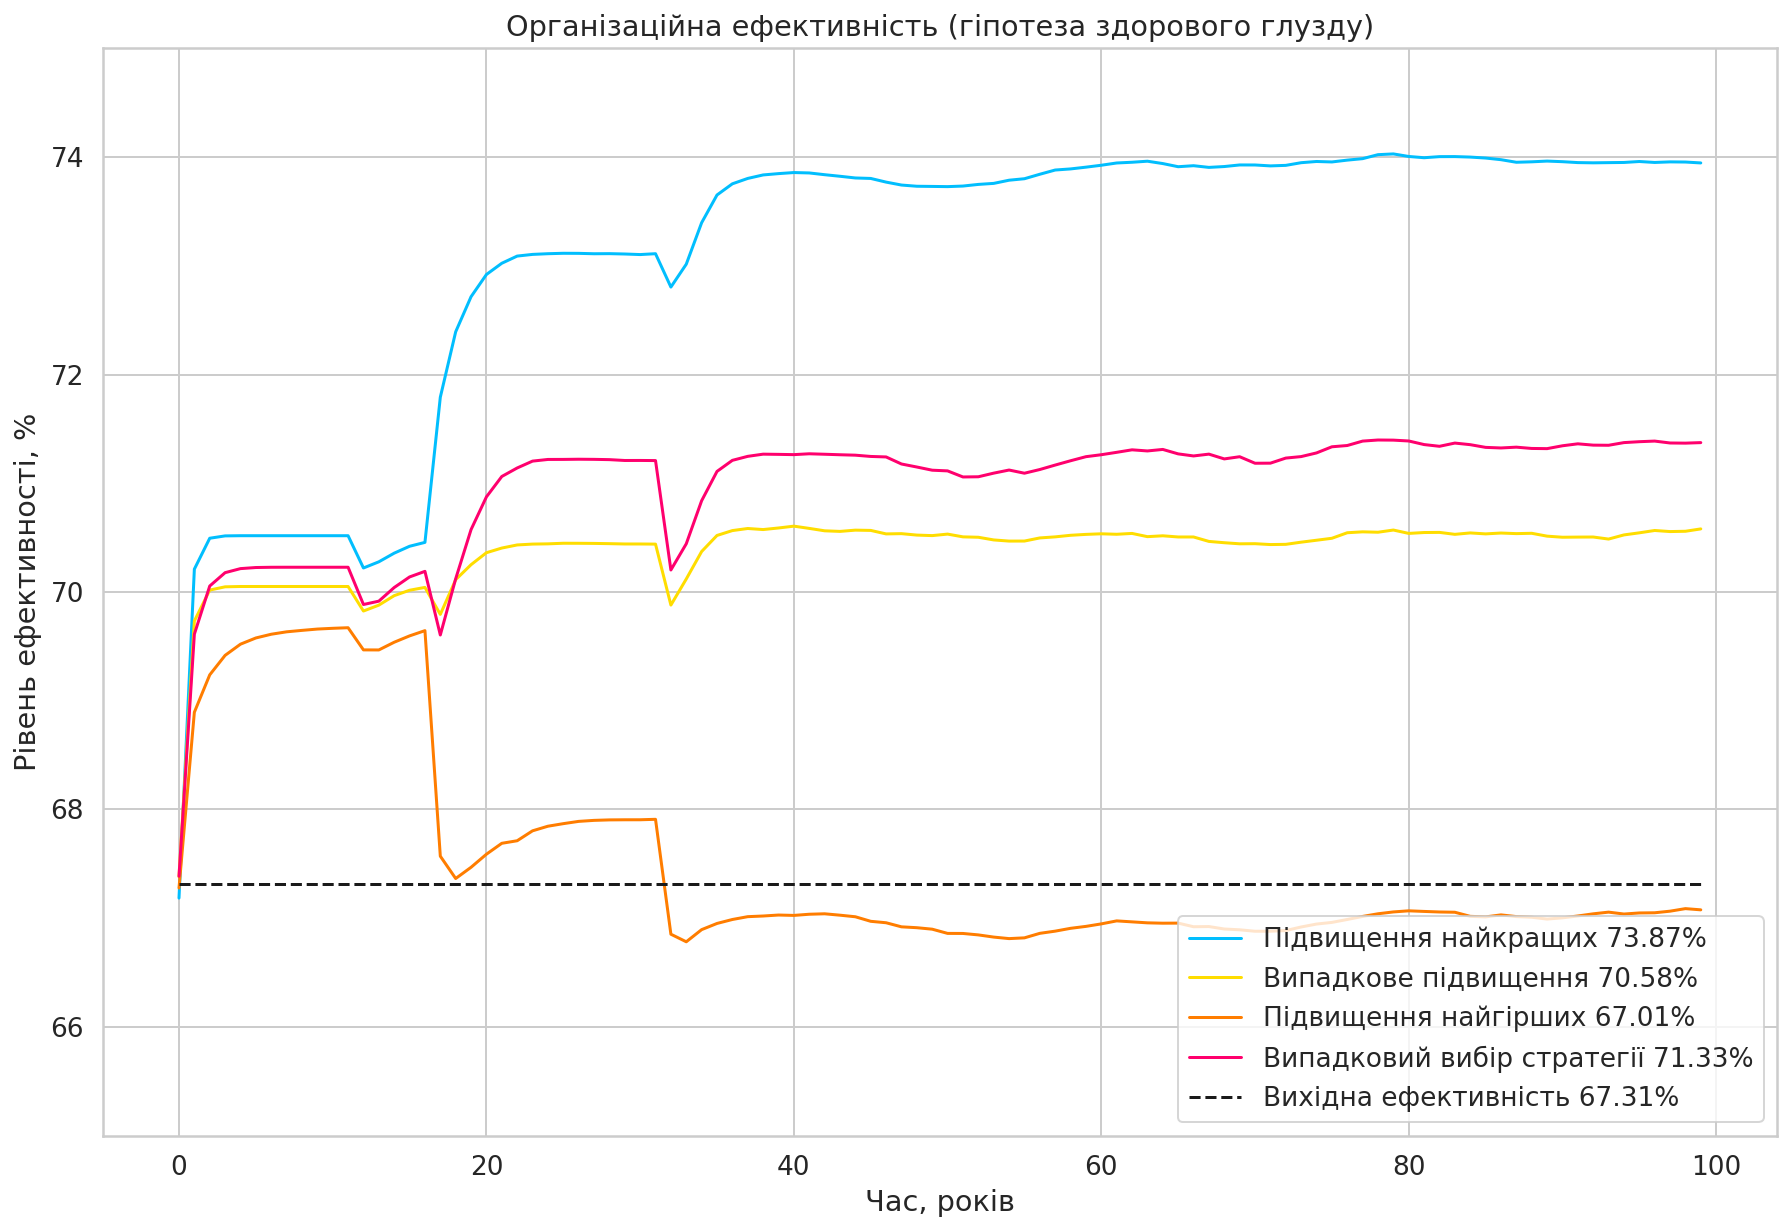

In [ ]:
plt.plot(range(epochs)[:100], efficiency[1][:100]*100, 
         label=f'Підвищення найкращих {round(np.mean(efficiency[1][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], efficiency[0][:100]*100, 
         label=f'Випадкове підвищення {round(np.mean(efficiency[0][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], efficiency[2][:100]*100, 
         label=f'Підвищення найгірших {round(np.mean(efficiency[2][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], efficiency[3][:100]*100, 
         label=f'Випадковий вибір стратегії {round(np.mean(efficiency[3][100:])*100, 2)}%')
plt.plot(range(epochs)[:100], 
         [round(np.mean([i[0] for i in efficiency])*100, 2)]*100, '--', 
         color='k', 
         label=f'Вихідна ефективність {round(np.mean([i[0] for i in efficiency])*100, 2)}%')

plt.ylim(65,75)
plt.title('Організаційна ефективність (гіпотеза здорового глузду)')
plt.ylabel('Рівень ефективності, %')
plt.xlabel('Час, років')
plt.legend(loc='lower right')



# Нейронна мережа (навчання з підкріпленням) - прототип

In [ ]:
import numpy as np
import random
import torch
from torch import nn
from operator import itemgetter
import copy

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
replay_memory = []
efficiency = []

param = {0:5, 1:51 , 2:300, 3:600, 4:440}

class GameState:
  def __init__(self):
    super(GameState, self).__init__()
    self.full_cycle = 0
    self.age_counter = 0

  def get_random(self, mode, value=None, level_num=0):
    ran = 0

    if mode=='competence_peter' or mode=='competence':
      while ran>10. or ran<1.:
        ran = random.gauss(7, 2)
      return ran

    elif mode == 'competence_common':
      variation = np.random.uniform(-1, 1)
      while value+variation<1. or value+variation>10.:
        variation = np.random.uniform(-1, 1)
      return value+variation

    elif mode == 'custom': return value+level_vars[level_num]

    elif mode=='age':
      while int(ran) not in range(18,61):
        ran = random.gauss(25, 5)
      return float(int(ran))


  #аналогічно агентному моделюванню
  def get_hierarchy(self):
     hierarchy = [
                  [[42, self.get_random('competence')] for i in range(5)],
                  [[45, self.get_random('competence')] for i in range(51)],
                  [[45, self.get_random('competence')] for i in range(300)],
                  [[30, self.get_random('competence')] for i in range(600)],
                  [[50, self.get_random('competence')] for i in range(440)]
     ]
     return hierarchy
  
  
  def calculate_efficiency(self, hierarchy):
    max_competences = np.array([10*len(level) for level in hierarchy])
    
    num_employees = sum(len(level) for level in hierarchy)
    coefs = np.array([.8,.7,.5,.4,.2])

    level_competences = np.array([sum([i[1] if len(level)!=0 else 0 for i in level]) for
                                  level in hierarchy])
    
    org_ef = np.matmul(coefs, level_competences)

    efficiency.append(org_ef/((np.matmul(coefs, max_competences)/num_employees) *
                              num_employees))
    
    

  def get_from_new(self, hierarchy):

    while [len(level) for level in hierarchy[:4]] == [param[i] for i in range(4)]:
      for level in hierarchy:
        for worker in level:
          if worker[0]>60 or worker[1]<4:
            level.remove(worker)
      if [len(level) for level in hierarchy[:4]] == [param[i] for i in range(4)]:
        self.age_counter+=1
        #print('+1 age')
        for level in hierarchy:
          for worker in level:
            age = worker[0]
            worker[0] = age+1
        
    
    for level in hierarchy: # sort every level by competence
      if len(level)!=0:
        hierarchy[hierarchy.index(level)] = sorted(level, key=lambda x: x[1])

    level_num=0
    while len(hierarchy[level_num]) == param[level_num]:
      level_num+=1
    else:
      state_ = hierarchy[level_num] # to promote to
      state_ = state_ + ([[0.,0.]]*(600-len(state_)))

      state_2 = hierarchy[level_num+1] # to promote from
      state_2 = state_2 + ([[0.,0.]]*(600-len(state_2)))


    return state_, state_2, level_num, hierarchy


  def get_first(self):
    hierarchy = self.get_hierarchy()
    

    state_, state_2, level_num, hierarchy = self.get_from_new(hierarchy)
    self.calculate_efficiency(hierarchy)

    mask = torch.ones([600])
    ind = dict(zip(range(600), state_2))
              
    for i in ind:
      if list(ind[i]) == [0.,0.]:
        mask[i] = -1e7
              
    return torch.tensor(state_).view(1,600,2), torch.tensor(state_2).view(1,600,2), hierarchy, level_num, mask.view(1,600)


  def step(self, action, state, hierarchy, level_num):
    #self.calculate_efficiency(hierarchy)
    state = state[0]

    worker_ind = list(action).index(1)

    prom = state[worker_ind]

    if list(prom)==[0.,0.]:
      print('ERROR', prom)
    #print(prom)
    # add to upper level

    hierarchy[level_num].append([prom[0], self.get_random('custom', prom[1], 
                                                          level_num)])    


    # remove from lower level
    state = torch.cat((state[:worker_ind], torch.tensor([[0.,0.]]), 
                       state[worker_ind+1:]))
    hierarchy[level_num+1] = [list(i) for i in state if list(i)!=[0.,0.]]
    
    
    """
    if efficiency[-1]-efficiency[-2]>0:
      reward = 1
    else:
      reward = -1
    """

    if level_num!=3:
      for level in hierarchy: # sort every level by competence
          if len(level)!=0:
            hierarchy[hierarchy.index(level)] = sorted(level, key=lambda x: x[1])
      
      terminal = False
      state_ = hierarchy[level_num+1] # to promote to
      state_ = state_ + ([[0.,0.]]*(600-len(state_)))

      state_2 = hierarchy[level_num+2] # to promote from
      state_2 = state_2 + ([[0.,0.]]*(600-len(state_2)))
      
      level_num+=1

    # if level to promote was 3 (4th/5)
    else:
      if [len(i) for i in hierarchy[:4]]==[param[i] for i in range(4)]:
        terminal=True

        ind = dict(zip(range(440), state))
        # replacing all [0,0] withe new workers
        for i in ind:
          if list(ind[i]) == [0.,0.]:
            state[i] = torch.tensor([self.get_random('age'), self.get_random('competence')])
        
        # replacing all 4th level
        hierarchy[4] = [list(i) for i in state if list(i)!=[0.,0.]]

        self.full_cycle += 1

        
        for level in hierarchy:
          for worker in level:
            age = worker[0]
            worker[0] = age+1
        self.age_counter+=1
        state_, state_2, level_num, hierarchy = self.get_from_new(hierarchy)

      # if we still have positions to fill
      else:
        terminal = False
        hierarchy[4].append([self.get_random('age'), self.get_random('competence')])
        
        for level in hierarchy: # sort every level by competence
          if len(level)!=0:
            hierarchy[hierarchy.index(level)] = sorted(level, key=lambda x: x[1])
        
        level_num=0
        while len(hierarchy[level_num]) == param[level_num]:
          level_num+=1
        else:
          state_ = hierarchy[level_num] # to promote to
          state_ = state_ + ([[0.,0.]]*(600-len(state_)))

          state_2 = hierarchy[level_num+1] # to promote from
          state_2 = state_2 + ([[0.,0.]]*(600-len(state_2)))

          
    mask_1 = torch.ones([600])
    ind = dict(zip(range(600), state_2))
              
    for i in ind:
      if list(ind[i]) == [0.,0.]:
        mask_1[i] = -1e7


    for i in hierarchy:
      if len(i)>param[hierarchy.index(i)]:
        print('ERROR')
        print(hierarchy)
        print([len(i) for i in hierarchy])
        print(level_num)
    

    self.calculate_efficiency(hierarchy)
    reward = (efficiency[-1]-efficiency[-2])*1e4
    #print(reward)
    #print(worker_ind)
    #print([len(i) for i in hierarchy])
    return torch.tensor(state_).view(1,600,2), torch.tensor(state_2).view(1,600,2), \
    reward, terminal, [[[float(val) for val in worker] for worker in level] for level in hierarchy], \
    level_num, mask_1.view(1,600)



Перевірка рівня ефективності організації при традиційній стратегії підвищення найкращих працівників

In [ ]:
def test_zeros():
    efficiency = []
    game_state = GameState()
    state, state_, hierarchy, level_num, mask = game_state.get_first()
    if torch.cuda.is_available():
      state = state.cuda()
      state_ = state_.cuda()

    level = 0

    while game_state.age_counter!=101:

        action = torch.zeros([600], dtype=torch.float32)
        if torch.cuda.is_available():  # put on GPU if CUDA is available
            action = action.cuda()

        # get action
        action_index = 0

        action[action_index] = 1

        # get next state
        state_1, state__1, reward, terminal, hierarchy, level_num, mask_1 = \
        game_state.step(action, state_, hierarchy, level_num)

        # set state to be state_1
        state = state_1
        state_ = state__1
        mask = mask_1

In [ ]:
averaged = []
for i in range(20):
  test_zeros()
  averaged.append(np.mean([float(i) for i in efficiency])*100)
  print(f'Iteration {i+1}/20 is done')
  print(f'Average_eff: {np.mean(averaged)}')

Значення ефективності (%)

In [ ]:
np.mean(averaged)

77.1316894826365

In [ ]:
efficiency

Архітектура нейронної мережі

In [ ]:
import math
import logging

import torch
import torch.nn as nn
from torch.nn import functional as F

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.kqv_dim)
        self.query = nn.Linear(config.n_embd, config.kqv_dim)
        self.value = nn.Linear(config.n_embd, config.kqv_dim)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.kqv_dim, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size() #2,216,2
        C = self.key(x).size(-1)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y


In [ ]:
class Config:
  n_embd = 2
  kqv_dim = 32
  n_head = 1
  block_size = 1
  embd_pdrop = 0.1
  resid_pdrop = 0.1
  attn_pdrop = 0.1

config = Config()



In [ ]:
class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

In [ ]:
class Reinforce(nn.Module):
  def __init__(self):
    super(Reinforce, self).__init__()
    self.number_of_actions = 600
    self.gamma = .999
    self.final_epsilon = .01
    self.initial_epsilon = .99
    self.number_of_iterations = 6000
    self.replay_memory_size = 10000
    self.minibatch_size = 128

    # input: [1,1296,2]
    
    self.block = Block(config)
    self.lin1 = nn.Linear(600*config.n_embd, self.number_of_actions)
    self.soft = nn.Softmax(1)
    

  def forward(self, x, mask):
    
    batch_size = x.size(0)

    x = x.float()

    x = self.block(x)
    x = x.view(batch_size,-1)
    x = self.lin1(x)


    mask = mask.view(batch_size,600)
    x = torch.where(mask>0, x, mask)
    x = self.soft(x)

    return x


def init_weights(module):
  if isinstance(module, (nn.Linear, nn.Embedding)):
      module.weight.data.normal_(mean=0.0, std=0.02)
      if isinstance(module, nn.Linear) and module.bias is not None:
          module.bias.data.zero_()
  elif isinstance(module, nn.LayerNorm):
      module.bias.data.zero_()
      module.weight.data.fill_(1.0)

In [ ]:
model = Reinforce()
print(model)

if torch.cuda.is_available():
  model = model.cuda()
model.apply(init_weights)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.SmoothL1Loss()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Number of parameters: {count_parameters(model)}')
epsilon = model.initial_epsilon
iteration = 1

epsilon_decrements = np.linspace(model.initial_epsilon, model.final_epsilon, model.number_of_iterations)

Reinforce(
  (block): Block(
    (ln1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (attn): CausalSelfAttention(
      (key): Linear(in_features=2, out_features=32, bias=True)
      (query): Linear(in_features=2, out_features=32, bias=True)
      (value): Linear(in_features=2, out_features=32, bias=True)
      (attn_drop): Dropout(p=0.1, inplace=False)
      (resid_drop): Dropout(p=0.1, inplace=False)
      (proj): Linear(in_features=32, out_features=2, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): GELU()
      (2): Linear(in_features=8, out_features=2, bias=True)
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (lin1): Linear(in_features=1200, out_features=600, bias=True)
  (soft): Softmax(dim=1)
)
Number of parameters: 721004


In [ ]:
game_state = GameState()
state, state_, hierarchy, level_num, mask = game_state.get_first()
if torch.cuda.is_available():
  state = state.cuda()
  state_ = state_.cuda()

print([len(i) for i in hierarchy])


[5, 47, 282, 564, 412]


Процес навчання. Стратегію підвищення пропонується обиратти відповідно до закономірностей вибору моделлю індексу кандидата на підвищення (Indicies) - чим ближчий він до 0, тим вища апріорна компетентність працівника, тим ймовірніше, що треба обирати найкращих, і навпаки.

In [ ]:
losses = []
rewards = []
iters = {}

while iteration < model.number_of_iterations:
    # get output from the neural network

    output = model(state, mask)[0]

    # initialize action
    action = torch.zeros([model.number_of_actions], dtype=torch.float32)
    if torch.cuda.is_available():  # put on GPU if CUDA is available
        action = action.cuda()

    # epsilon greedy exploration
    random_action = random.random() <= epsilon
    #if random_action: print("Performed random action!")
    #else: print("Chose max output!")
    indicies = (output!=0).nonzero()
    action_index = [torch.randint(len(indicies), torch.Size([]), dtype=torch.int)
                    if random_action
                    else torch.argmax(output)][0]

    if torch.cuda.is_available():  # put on GPU if CUDA is available
        action_index = action_index.cuda()

    action[action_index] = 1

    # get next state and reward
    state_1, state__1, reward, terminal, hierarchy, level_num_1, mask_1 = game_state.step(action, state_, hierarchy, level_num)
    #print([len(i) for i in hierarchy])
    rewards.append(float(reward))

    
    action = action.unsqueeze(0)
    reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0)

    # save transition to replay memory
    replay_memory.append((state, mask, action, reward, state_1, terminal, mask_1, torch.tensor([level_num])))

    # if replay memory is full, remove the oldest transition
    if len(replay_memory) > model.replay_memory_size:
        replay_memory.pop(0)

    # epsilon annealing
    epsilon = epsilon_decrements[iteration]

    # sample random minibatch
    minibatch = random.sample(replay_memory, min(len(replay_memory), model.minibatch_size))

    # unpack minibatch
    state_batch = torch.cat(tuple(d[0] for d in minibatch))
    mask_batch = torch.cat(tuple(d[1] for d in minibatch))
    action_batch = torch.cat(tuple(d[2] for d in minibatch))
    reward_batch = torch.cat(tuple(d[3] for d in minibatch))
    state_1_batch = torch.cat(tuple(d[4] for d in minibatch))
    mask_1_batch = torch.cat(tuple(d[6] for d in minibatch))
    level_num_batch = torch.cat(tuple(d[7] for d in minibatch))
    

    if torch.cuda.is_available():  # put on GPU if CUDA is available
        state_batch = state_batch.cuda()
        mask_batch = mask_batch.cuda()
        action_batch = action_batch.cuda()
        reward_batch = reward_batch.cuda()
        state_1_batch = state_1_batch.cuda()
        mask_1_batch = mask_batch.cuda()
        level_num_batch = level_num_batch.cuda()
    #print(state_1_batch.size())
    # get output for the next state
    output_1_batch = model(state_1_batch, mask_1_batch)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y_batch = torch.cat(tuple(reward_batch[i] if minibatch[i][5]
                              else reward_batch[i] + model.gamma * torch.max(output_1_batch[i])
                              for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(model(state_batch, mask_batch) * action_batch, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y_batch = y_batch.detach()

    # calculate loss
    loss = criterion(q_value, y_batch)
    losses.append(loss.item())

    if iteration % 1000 == 0:
      print(f'Epoch: {iteration}/{model.number_of_iterations}')
      print('Av loss: ', np.mean(losses[-1000:]))
      #print(hierarchy)
      print([len(i) for i in hierarchy])
      print('Efficiency: ', np.mean([float(i) for i in efficiency[-1000:]]))
      #competences = [hierarchy_batch[i][list(action_batch[i]).index(1)] for i in range(model.minibatch_size)]
      indicies_ = [list(action_batch[i]).index(1) for i in range(model.minibatch_size)]
      #print('Competences: ', competences)
      print('Indicies: ', indicies_)
      #print(f'Average age: {torch.mean(torch.tensor([i[0] for i in competences]))}, average comp: {torch.mean(torch.tensor([i[1] for i in competences]))}')
      print(f'Level promoted to: {[int(level_num_batch[i])+1 for i in range(model.minibatch_size)]}')
      #print(f'Level promoted from: {[int(level_num_batch[i])+2 for i in range(model.minibatch_size)]}')
      print('Epsilon: ', epsilon)
      print('Rewards: ', np.mean(rewards[-1000:]))
      #print(f'Share of non-zero: {round((len([i for i in competences if list(i)!=[0.,0.]])/len(competences))*100, 2)}%')
      torch.save(model.state_dict(), f'weights_{iteration}.pt')
      iters[iteration] = np.mean([float(i) for i in efficiency[-1000:]])

    # do backward pass
    loss.backward()
    optimizer.step()

    # set state to be state_1
    state = state_1
    state_ = state__1
    mask = mask_1
    level_num = level_num_1
    #hierarchy = hierarchy_1
    iteration += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


Epoch: 1000/6000
Av loss:  2.002064822733402
[4, 34, 193, 380, 438]
Efficiency:  0.7259964062571526
Indicies:  [0, 0, 84, 0, 0, 0, 0, 0, 7, 229, 0, 0, 116, 118, 1, 0, 90, 313, 0, 0, 0, 165, 0, 0, 103, 0, 84, 0, 84, 200, 1, 0, 0, 0, 0, 84, 0, 0, 0, 84, 84, 96, 0, 84, 0, 0, 0, 0, 0, 0, 248, 192, 0, 0, 0, 0, 0, 0, 0, 50, 0, 0, 84, 0, 0, 0, 0, 0, 0, 0, 0, 2, 54, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 39, 0, 0, 137, 0, 0, 84, 0, 0, 0, 132, 0, 84, 0, 0, 0, 3, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 84, 0, 0, 84, 0, 0, 217, 152, 0]
Level promoted to: [4, 4, 2, 3, 4, 4, 4, 3, 2, 2, 4, 4, 2, 2, 3, 4, 2, 3, 4, 4, 4, 2, 4, 4, 3, 3, 3, 4, 3, 2, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 3, 3, 4, 3, 4, 4, 4, 4, 2, 2, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 3, 4, 3, 3, 4, 4, 4, 3, 2, 4, 3, 3, 4, 3, 3, 2, 3, 4, 3, 4, 3, 3, 3, 1, 4, 4, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 4, 4, 2, 3, 4]
Epsilon:  0.8266394399066511
Rewards:  0.702183841705322

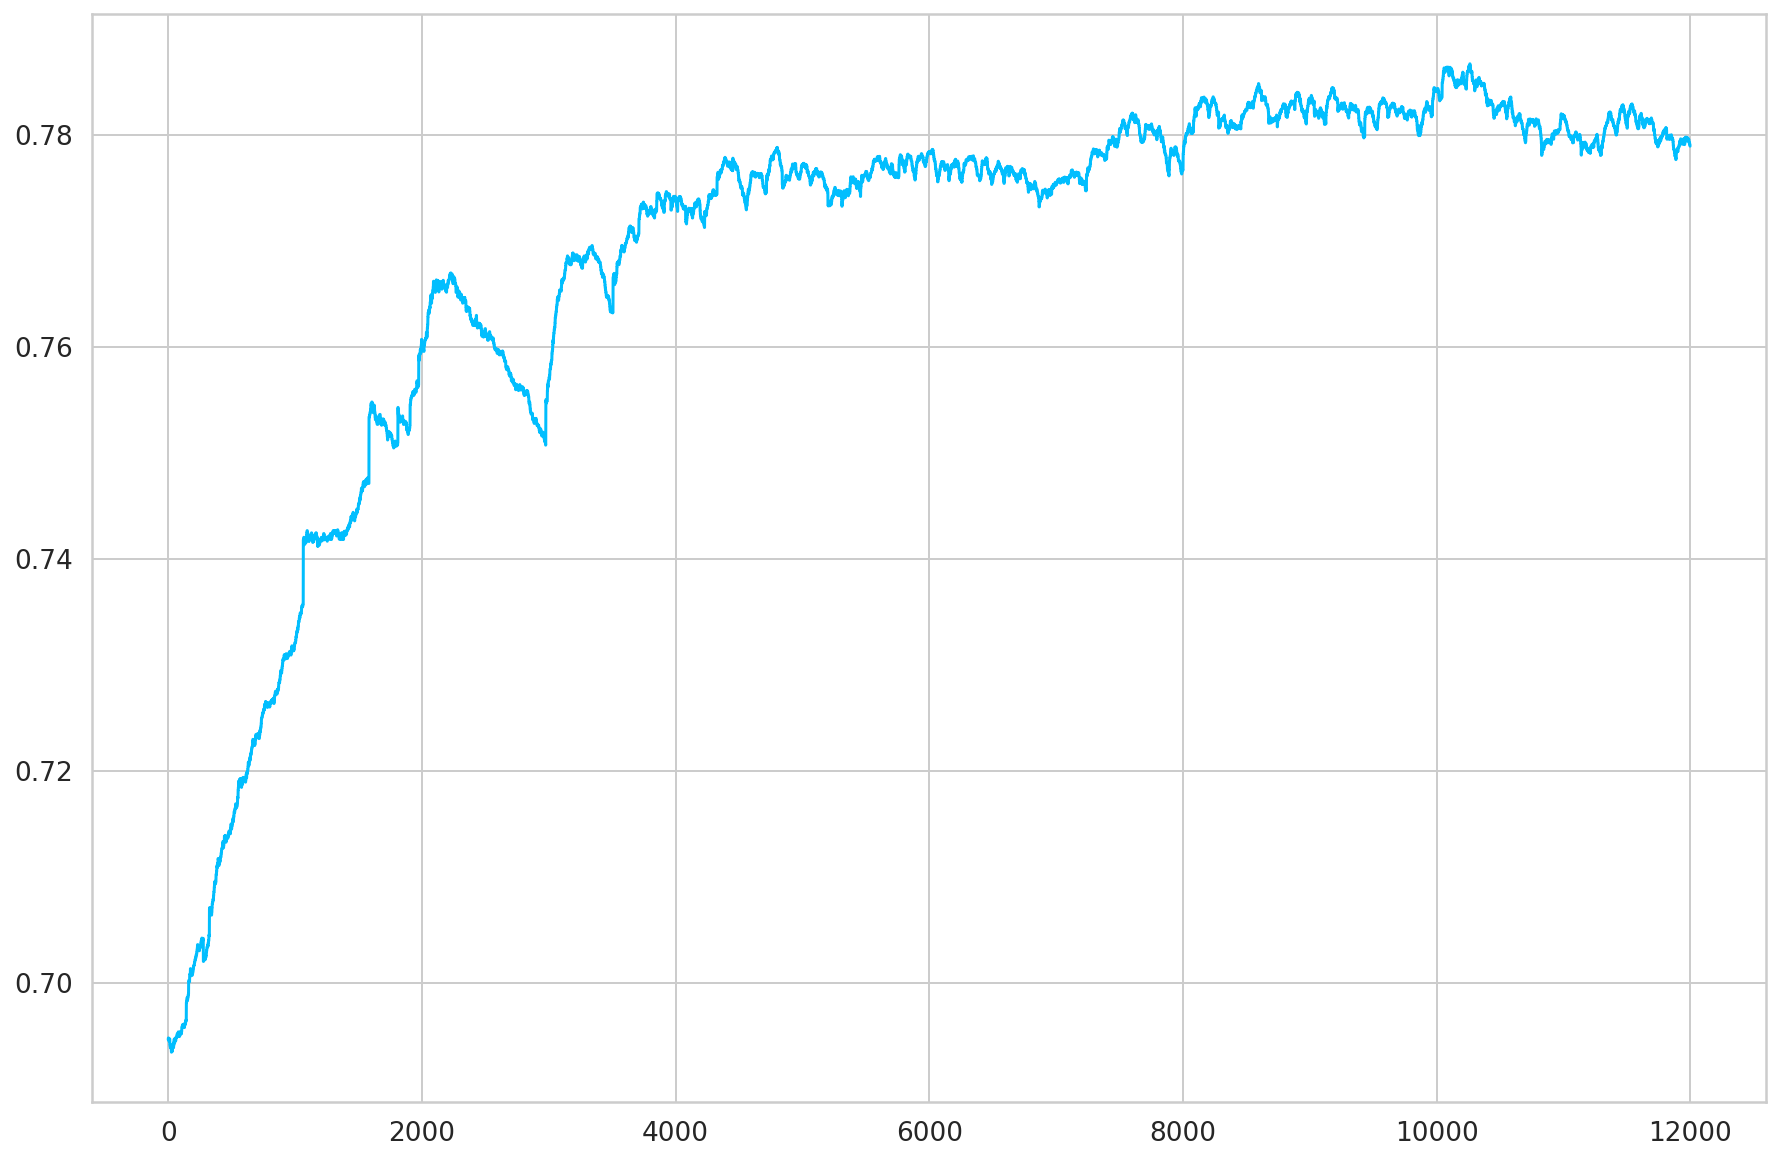

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 15, 10


plt.plot(range(len(efficiency)), efficiency)
#plt.plot(range(model.number_of_iterations-1), losses)
plt.show()

In [ ]:
best_iter = max(iters, key=iters.get)

In [ ]:
best_iter

4000

In [ ]:
model.load_state_dict(torch.load(f'weights_{best_iter}.pt'))
model.eval()

Reinforce(
  (block): Block(
    (ln1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (attn): CausalSelfAttention(
      (key): Linear(in_features=2, out_features=32, bias=True)
      (query): Linear(in_features=2, out_features=32, bias=True)
      (value): Linear(in_features=2, out_features=32, bias=True)
      (attn_drop): Dropout(p=0.1, inplace=False)
      (resid_drop): Dropout(p=0.1, inplace=False)
      (proj): Linear(in_features=32, out_features=2, bias=True)
    )
    (mlp): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): GELU()
      (2): Linear(in_features=8, out_features=2, bias=True)
      (3): Dropout(p=0.1, inplace=False)
    )
  )
  (lin1): Linear(in_features=1200, out_features=600, bias=True)
  (soft): Softmax(dim=1)
)

In [ ]:
model.load_state_dict(torch.load('weights_4000 (1).pt'))
model.eval()

Тестування навченої стратегії. Відсоток ефективності організації може бути дещо нижчим за відповідне значення під час навчання.

In [ ]:
def test(model):
    efficiency = []
    game_state = GameState()
    state, state_, hierarchy, level_num, mask = game_state.get_first()
    if torch.cuda.is_available():
      state = state.cuda()
      state_ = state_.cuda()

    level = 0

    while game_state.age_counter!=101:
        # get output from the neural network
        output = model(state, mask)[0]

        action = torch.zeros([model.number_of_actions], dtype=torch.float32)
        if torch.cuda.is_available():  # put on GPU if CUDA is available
            action = action.cuda()

        # get action
        action_index = torch.argmax(output)
        if torch.cuda.is_available():  # put on GPU if CUDA is available
            action_index = action_index.cuda()
        action[action_index] = 1

        # get next state
        state_1, state__1, reward, terminal, hierarchy, level_num, mask_1 = game_state.step(action, state_, hierarchy, level_num)


        # set state to be state_1
        state = state_1
        state_ = state__1
        mask = mask_1

In [ ]:
averaged

In [ ]:
averaged_test = []
for i in range(20):
  test(model)
  averaged_test.append(np.mean([float(i) for i in efficiency])*100)
  print(f'Iteration {i+1}/20 is done')
  print(f'Average_eff: {np.mean(averaged_test)}')

In [ ]:
np.mean([float(i) for i in efficiency])*100

76.4377911016505